# Neo4j GraphRAG Retriever Notebook

This notebook demonstrates how to use various retrievers and Cypher patterns with Neo4j GraphRAG for asset manager and cybersecurity risk retrieval.


In [ ]:
%pip install -r requirements.txt

In [1]:
import os
from neo4j import GraphDatabase
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.retrievers import VectorRetriever, VectorCypherRetriever, Text2CypherRetriever
from neo4j_graphrag.generation import GraphRAG
from neo4j_graphrag.schema import get_schema
from dotenv import load_dotenv
import pandas as pd
from IPython.display import display, HTML
import textwrap

from IPython.core.display import HTML
display(HTML("<style>.output_area pre {white-space: pre-wrap; word-break: break-word;}</style>"))

# Load environment variables
load_dotenv()
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USER = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))


## Initialize LLM and Embedder

This section sets up the Large Language Model (LLM) and the embedding model for use in retrieval-augmented generation (RAG) workflows.

- **LLM**: Uses OpenAI's GPT-4o model via the `OpenAILLM` interface.
- **Embedder**: Uses OpenAI's embedding API via the `OpenAIEmbeddings` class.

> **Note:**  
> - The `OPENAI_API_KEY` must be set in your environment variables or [.env](cci:7://file:///c:/Users/Alison%20Cossette/OneDrive/GitHub/graphrag-ebook/.env:0:0-0:0) file.
> - You can adjust model parameters (such as response format or temperature) by modifying the commented-out `model_params` dictionary if needed.


In [2]:
# --- Initialize LLM and Embedder ---
###model_params = {"response_format": {"type": "json_object"},  # use json_object formatting for best results
###                "temperature": 0  # turning temperature down for more deterministic results
###                }

llm = OpenAILLM(model_name='gpt-4o', api_key=OPENAI_API_KEY)
embedder = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

## About Vector Search

Vector search enables semantic retrieval of text chunks from your Neo4j graph.  
Instead of keyword matching, it finds the most contextually similar passages to your query, even if the wording is different.

**Tip:**  
Inspect the returned results to verify relevance and adjust your chunking or embedding strategy if needed.

# Initialize Vector Retriever
This section sets up the vector-based retriever for semantic search over your Neo4j knowledge graph.

- **Query:**  
  The example query asks, "What are the risks that Apple faces?"

- **VectorRetriever:**  
  - Connects to the Neo4j database using the provided `driver`.
  - Uses the `chunkEmbeddings` vector index for efficient semantic retrieval.
  - The `embedder` generates embeddings for the query.
  - Returns the `text` property from matching chunks.

> **Tip:**  
> You can modify the `return_properties` list to include additional properties from the retrieved nodes if needed.

In [3]:
# --- Initialize Vector Retriever ---

query = "What are the risks that Apple faces?"

vector_retriever = VectorRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    return_properties=['text'])

# Simple Vector Search Diagnostic 

This section performs a diagnostic semantic search using the vector retriever.

- **Purpose:**  
  Quickly test the vector search by retrieving the top 10 most relevant text chunks from the Neo4j knowledge graph for the given query.

- **How it works:**  
  1. `vector_retriever.search()` runs the query and returns the top 10 matches based on vector similarity.
  2. The results are formatted into a pandas DataFrame, displaying:
     - The similarity score (`Score`)
     - A snippet of the retrieved content (`Content`)
     - The unique identifier for each chunk (`ID`)

- **Usage:**  
  This diagnostic helps you verify that the vector search is working and inspect the quality of the top results for your query.


In [4]:
    # --- Simple Vector Search Diagnostic ---

result = vector_retriever.search(query_text=query, top_k=10)
result_table=pd.DataFrame([(item.metadata['score'], item.content[10:80], item.metadata['id']) for item in result.items], columns=['Score', 'Content', 'ID'])
result_table

,Score,Content,ID
0,0.917023,"the Company to potential liabilities, increase...",4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:996
1,0.913254,"relief against the Company, and has\nfrom time...",4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:995
2,0.912247,in both\nfrequency and sophistication with in...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:993
3,0.910599,interruptions can harm or disrupt internationa...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:984
4,0.909454,impact the Company\'s net sales to its indirec...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:982
5,0.908188,conditions and adverse economic conditions can...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:988
6,0.907639,perception and analysis of the relative benefi...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:990
7,0.907532,intended to be inactive\ntextual references on...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:983
8,0.906799,sults.\nApple Inc. | 2023 Form 10-K | 25\nSect...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:1005
9,0.906555,interruption\naffecting such sources would exa...,4:bba0d29d-fe34-452f-84da-8ff1e8caa7f2:985


# Retrieval-Augmented Generation (RAG) Query

This section demonstrates how to use the `GraphRAG` class to perform a retrieval-augmented generation workflow:

- **GraphRAG**:  
  Combines a Large Language Model (LLM) with a vector-based retriever to answer questions using both semantic search and generative reasoning.

- **How it works:**  
  1. The retriever (`vector_retriever`) finds the most relevant text chunks from the Neo4j graph based on the input query.
  2. The LLM (`llm`) uses the retrieved context to generate a natural language answer.
  3. The answer is printed directly.

- **Usage:**  
  This approach provides context-aware, accurate answers grounded in your knowledge graph data.


In [5]:
rag = GraphRAG(
    llm=llm,
    retriever=vector_retriever
)
#print(textwrap.fill(rag.search(query).answer, width=80))
print(rag.search(query).answer)

Apple faces several risks that could materially adversely affect its business, reputation, results of operations, and financial condition. These include:

1. **Regulatory and Legal Challenges**: Apple is subject to intense regulatory scrutiny, including antitrust investigations globally, which could result in significant fines and require changes to its business practices. Compliance with complex and changing laws worldwide, including those related to privacy, consumer protection, and e-commerce, increases costs and can disrupt operations.

2. **Environmental, Social, and Governance (ESG) Issues**: There is increasing focus on ESG matters, and Apple faces risks associated with meeting these expectations and its own announced goals. Failure or perceived failure to achieve ESG objectives could result in legal and regulatory challenges.

3. **Supply Chain and Trade Restrictions**: Apple's operations and supply chain depend heavily on international trade, and any restrictions, tariffs, or 

## Advanced RAG: Contextual Cypher Retrieval

This section demonstrates how to use a custom Cypher query with the `VectorCypherRetriever` to provide richer, more contextual answers.

- **Custom Cypher Query:**  
  The `detail_context_query` matches text chunks (`node`) to their source documents, associated companies, and the risk factors those companies face.  
  It returns:
  - The company name
  - The context text from the chunk
  - A list of distinct risk factors

- **VectorCypherRetriever:**  
  - Performs semantic search using the `chunkEmbeddings` vector index.
  - Applies the custom Cypher query to retrieve relevant context and associated risk factors.

- **GraphRAG:**  
  - Combines the LLM and the custom retriever to answer the question:  
    _"What are the top risk factors that Apple faces?"_

- **Usage:**  
  This approach enables highly specific, context-rich answers by leveraging the full power of graph relationships and semantic search.


In [6]:
# --- VectorCypherRetriever Example: Detailed Search with Context ---  OR WHY THIS IS A BAD QUERY :)

detail_context_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(company:Company)-[:FACES_RISK]-(risk:RiskFactor)
RETURN company.name AS company,  node.text AS context, collect(DISTINCT risk.name) AS risks
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    retrieval_query=detail_context_query
)


In [7]:

rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
query = "What are the top risk factors that Apple faces?"
print(rag.search(query).answer)

The top risk factors that Apple faces include:

1. Cybersecurity Attacks: Risks related to data breaches, hacking, and unauthorized access due to Apple's high profile and valuable information it handles.

2. Supply Chain Disruptions: Potential issues with manufacturing, supply shortages, price increases, and the effects of natural or political disruptions.

3. Macroeconomic and Industry Risks: Adverse global or regional economic conditions affecting consumer confidence and spending.

4. Legal and Regulatory Compliance Risks: Complex and changing laws and regulatory scrutiny, including antitrust investigations and changes to the App Store influenced by legislative initiatives.

5. Privacy and Data Protection Concerns: Challenges involving compliance with data protection laws and maintaining a secure environment for personal and financial data.

6. Climate Change and Environmental Considerations: Impact on operations and reputation due to environmental regulations and stakeholder expecta

In [8]:
result = vector_cypher_retriever.search(query_text=query, top_k=10)
for item in result.items:
    print(item.content[:100])


<Record company='APPLE INC' context='impact the Company\'s net sales to its indirect distribution\nc
<Record company='APPLE INC' context=" in both\nfrequency and sophistication with increasing use by a
<Record company='APPLE INC' context='intended to be inactive\ntextual references only.\nApple Inc. |
<Record company='APPLE INC' context="the Company to potential liabilities, increased costs, reputati
<Record company='APPLE INC' context='perception and analysis of the relative benefits of\ndeveloping
<Record company='APPLE INC' context='conditions and adverse economic conditions can materially adver
<Record company='APPLE INC' context="interruptions can harm or disrupt international\ncommerce and t
<Record company='APPLE INC' context='sults.\nApple Inc. | 2023 Form 10-K | 25\nSection: Item7a\n>Ite
<Record company='APPLE INC' context="relief against the Company, and has\nfrom time to time required
<Record company='APPLE INC' context="interruption\naffecting such sources would exacerbate 

In [9]:
result = vector_cypher_retriever.search(query_text=query, top_k=20)
for item in result.items:
    print(item.content[:100])


<Record company='APPLE INC' context='impact the Company\'s net sales to its indirect distribution\nc
<Record company='APPLE INC' context=" in both\nfrequency and sophistication with increasing use by a
<Record company='APPLE INC' context='intended to be inactive\ntextual references only.\nApple Inc. |
<Record company='APPLE INC' context="the Company to potential liabilities, increased costs, reputati
<Record company='APPLE INC' context='perception and analysis of the relative benefits of\ndeveloping
<Record company='APPLE INC' context='conditions and adverse economic conditions can materially adver
<Record company='APPLE INC' context="interruptions can harm or disrupt international\ncommerce and t
<Record company='APPLE INC' context='sults.\nApple Inc. | 2023 Form 10-K | 25\nSection: Item7a\n>Ite
<Record company='APPLE INC' context="relief against the Company, and has\nfrom time to time required
<Record company='APPLE INC' context="interruption\naffecting such sources would exacerbate 

## Why "Apple" Queries Can Fail in Vector-Cypher Retrieval

When you ask a question like "What are the risks that Apple faces?" using a vector-Cypher retriever, you may not get the structured or complete answer you expect. Here’s why:

- **How Vector-Cypher Works:**  
  - The retrieval process first performs a semantic search over all text chunks in the graph.
  - It retrieves the top-k chunks most similar to your query—regardless of which company (or entity) they are about.
  - The Cypher query then starts from each chunk and traverses the graph for related information.

- **The Problem with Entity-Centric Queries:**  
  - If your query is about "Apple," but there are no chunks whose text is semantically similar to your query and also specifically about Apple, the retriever may return:
    - Chunks about other companies.
    - Chunks that mention "risk" but not "Apple."
    - Generic or boilerplate risk factor text.
  - The Cypher query can only traverse from the retrieved chunk—it cannot "filter" or "redirect" to Apple if the chunk isn’t already about Apple.

- **Key Limitation:**  
  - **The chunk is the anchor.** If your query is about an entity (like Apple), but the chunk retrieval is not entity-aware, you may never reach the correct node or context in the graph.
  - This is especially problematic for broad or entity-centric questions, where you want to aggregate or summarize information about a specific node (e.g., a company) rather than just retrieve semantically similar passages.

> **Conclusion:**  
> Vector-Cypher retrieval is powerful for finding relevant context, but it is fundamentally limited by the chunk-centric approach. For entity-centric questions, you need either:
> - Chunks that are explicitly about the entity, or
> - A retrieval/query strategy that starts from the entity node itself, not from arbitrary text chunks.

In [12]:
# --- VectorCypherRetriever Example: Detailed Search with Context ---  OR WHY THIS IS A GOOD QUERY :)
query_text = "Which Asset Managers are most affected by cryptocurrency policies?"

chunk_to_asset_manager_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(company:Company)-[:OWNS]-(manager:AssetManager)
RETURN company.name AS company, manager.managerName AS AssetManagerWithSharesInCompany, node.text AS context
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    retrieval_query=chunk_to_asset_manager_query
)

result = vector_cypher_retriever.search(query_text=query_text, top_k=10)
for item in result.items:
    print(item.content[:200])


<Record company='NVIDIA CORPORATION' AssetManagerWithSharesInCompany='ALLIANCEBERNSTEIN L.P.' context='changes in cryptocurrencies, government cryptocurrency policies and\nregulations, new cryptocurre
<Record company='NVIDIA CORPORATION' AssetManagerWithSharesInCompany='AMERIPRISE FINANCIAL INC' context='changes in cryptocurrencies, government cryptocurrency policies and\nregulations, new cryptocur
<Record company='NVIDIA CORPORATION' AssetManagerWithSharesInCompany='AMUNDI' context='changes in cryptocurrencies, government cryptocurrency policies and\nregulations, new cryptocurrency standards, a
<Record company='NVIDIA CORPORATION' AssetManagerWithSharesInCompany='BANK OF AMERICA CORP /DE/' context='changes in cryptocurrencies, government cryptocurrency policies and\nregulations, new cryptocu
<Record company='NVIDIA CORPORATION' AssetManagerWithSharesInCompany='Bank of New York Mellon Corp' context='changes in cryptocurrencies, government cryptocurrency policies and\nregulations, new c

In [13]:
rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
print(rag.search(query_text=query_text).answer)

The Asset Managers most affected by cryptocurrency policies, as they have shares in NVIDIA CORPORATION, are:

1. ALLIANCEBERNSTEIN L.P.
2. AMERIPRISE FINANCIAL INC
3. AMUNDI
4. BANK OF AMERICA CORP /DE/
5. Bank of New York Mellon Corp
6. BlackRock Inc.
7. Capital World Investors
8. FMR LLC
9. GEODE CAPITAL MANAGEMENT, LLC
10. MORGAN STANLEY
11. NORTHERN TRUST CORP
12. STATE STREET CORP
13. WELLINGTON MANAGEMENT GROUP LLP
14. WELLS FARGO & COMPANY/MN


## Let's try another query

In [17]:
## VectorCypherRetriever Example: Detailed Search with Context ---  OR WHY THIS IS A GOOD QUERY :)
asset_manager_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(company:Company)-[:OWNS]-(manager:AssetManager)
RETURN company.name AS company, manager.managerName AS AssetManagerWithSharesInCompany, node.text AS context
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name='chunkEmbeddings',
    embedder=embedder,
    retrieval_query=asset_manager_query
)


In [18]:
rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
query = "Who are the asset managers most affected by banking regulations?"
print(rag.search(query).answer)

The asset managers most affected by banking regulations, in the context of the provided data, include ALLIANCEBERNSTEIN L.P., AMERIPRISE FINANCIAL INC, AMUNDI, BANK OF AMERICA CORP /DE/, Bank of New York Mellon Corp, BlackRock Inc., Capital World Investors, FMR LLC, GEODE CAPITAL MANAGEMENT, LLC, MORGAN STANLEY, NORTHERN TRUST CORP, STATE STREET CORP, WELLINGTON MANAGEMENT GROUP LLP, and WELLS FARGO & COMPANY/MN, as they are asset managers with shares in Microsoft Corp, which is subject to various regulatory risks.


In [19]:
result = vector_cypher_retriever.search(query_text=query)
for item in result.items:
    print(item.content[:200])

<Record company='MICROSOFT CORP' AssetManagerWithSharesInCompany='ALLIANCEBERNSTEIN L.P.' context="restrain the flow of\ntechnical and professional talent may inhibit our ability to adequately staff o
<Record company='MICROSOFT CORP' AssetManagerWithSharesInCompany='AMERIPRISE FINANCIAL INC' context="restrain the flow of\ntechnical and professional talent may inhibit our ability to adequately staff
<Record company='MICROSOFT CORP' AssetManagerWithSharesInCompany='AMUNDI' context="restrain the flow of\ntechnical and professional talent may inhibit our ability to adequately staff our research and\
<Record company='MICROSOFT CORP' AssetManagerWithSharesInCompany='BANK OF AMERICA CORP /DE/' context="restrain the flow of\ntechnical and professional talent may inhibit our ability to adequately staf
<Record company='MICROSOFT CORP' AssetManagerWithSharesInCompany='Bank of New York Mellon Corp' context="restrain the flow of\ntechnical and professional talent may inhibit our ability to adequate

## VectorCypherRetriever Example: Detailed Search with Context — Why This Is a Good Query

This example demonstrates how to use `VectorCypherRetriever` to answer nuanced, relationship-driven questions by combining semantic search with graph traversal.

**Why this is a good query:**

- **Semantic Relevance:**  
  The vector retriever surfaces text chunks that are semantically similar to the question ("Who are the asset managers most affected by banking regulations?"). This grounds the search in passages that actually discuss asset managers and regulations.

- **Graph Contextualization:**  
  The Cypher query starts from each relevant chunk and traverses the graph to:
    - Find the source document.
    - Identify the company associated with the document.
    - Traverse to asset managers that own or are related to that company.

- **Structured and Contextual Output:**  
  The result provides:
    - The company name (`company`)
    - The asset manager’s name (`manager`)
    - The text context from the original chunk (`context`)

- **Why it works well:**  
  - The question is naturally chunk-centric: you want to find meaningful passages about asset managers and regulations, then extract structured information about the entities involved.
  - The graph traversal enriches the answer, linking unstructured context (text) to structured graph entities (companies, managers).
  - This approach leverages the best of both worlds: semantic search for relevance, and graph queries for structure and relationships.

**Summary:**  
This pattern is ideal when your question is about relationships or context that can be surfaced from relevant passages, and when you want to return both the context and the structured entities connected to it.  
It is less effective for purely entity-centric aggregation (like "all risks for Apple"), but perfect for questions where the chunk is the natural anchor for graph exploration.


In [20]:
result = vector_cypher_retriever.search(query_text=query, top_k=3)
for item in result.items:
    print(item.content)

<Record company='MICROSOFT CORP' AssetManagerWithSharesInCompany='ALLIANCEBERNSTEIN L.P.' context="restrain the flow of\ntechnical and professional talent may inhibit our ability to adequately staff our research and\ndevelopment efforts. If we are less successful in our recruiting efforts, or if we cannot retain highly\nskilled workers and key leaders, our ability to develop and deliver successful products and services\nmay be adversely affected. Effective succession planning is also important to our long-term success.\nFailure to ensure effective transfer of knowledge and smooth transitions involving key employees\ncould hinder our strategic planning and execution. How employment-related laws are interpreted\nand applied to our workforce practices may result in increased operating costs and less flexibility in\nhow we meet our workforce needs. Our global workforce is predominantly non-unionized, although\nwe do have some employees in the U.S. and internationally who are represented by


## VectorCypherRetriever Example: Finding Shared Risks Among Companies

This example demonstrates how to combine semantic search with graph traversal to uncover relationships—specifically, risks that connect major tech companies.

**How this query works:**

- **Semantic Search:**  
  The vector retriever finds the top-k text chunks most relevant to your query ("What risks connect major tech companies?").

- **Graph Traversal:**  
  For each retrieved chunk (`node`):
  - Follows the `:FROM_DOCUMENT` and `:FILED` relationships to a company (`c1`).
  - Finds all risk factors (`risk`) that `c1` faces.
  - Finds other companies (`c2`) that also face the same risk factor.
  - Ensures that `c1` and `c2` are different companies.

- **Returns:**  
  - `source_company`: The company from the retrieved chunk.
  - `related_companies`: Companies sharing at least one risk with the source company.
  - `shared_risks`: The names of the risk factors connecting these companies.

- **Why this is powerful:**  
  - Leverages the chunk as the semantic anchor, but then uses graph logic to discover structured, multi-entity relationships.
  - Surfaces both the context (from the chunk) and the broader network of shared risks—something that pure semantic or pure graph search alone would struggle to do as effectively.

> **Summary:**  
> This approach is ideal for exploratory questions about relationships in your graph, where you want to start from relevant context but end up with structured, comparative insights.


In [21]:
vector_company_risk_query = """
WITH node
MATCH (node)-[:FROM_DOCUMENT]-(doc:Document)-[:FILED]-(c1:Company)
MATCH (c1)-[:FACES_RISK]-(risk:RiskFactor)-[:FACES_RISK]-(c2:Company)
WHERE c1 <> c2
RETURN
  c1.name AS source_company,
  collect(DISTINCT c2.name) AS related_companies,
  collect(DISTINCT risk.name) AS shared_risks
LIMIT 10
"""

vector_cypher_retriever = VectorCypherRetriever(
    driver=driver,
    index_name="chunkEmbeddings",
    embedder=embedder,
    retrieval_query=vector_company_risk_query
)

query = "What risks connect major tech companies?"
result = vector_cypher_retriever.search(query_text=query, top_k=5)
for item in result.items:
    print(item.content)

<Record source_company='MICROSOFT CORP' related_companies=['PAYPAL', 'PG&E CORP'] shared_risks=['Cyberattacks and security vulnerabilities', 'climate change', 'foreign currency exchange rate movements', 'COVID-19 pandemic', 'COVID-19 pandemic impact']>
<Record source_company='AMAZON' related_companies=['APPLE INC', 'PG&E CORP'] shared_risks=['Interest Rate Risk', 'Inflation']>
<Record source_company='PAYPAL' related_companies=['MICROSOFT CORP', 'PG&E CORP', 'NVIDIA CORPORATION', 'APPLE INC'] shared_risks=['Cyberattacks and security vulnerabilities', 'climate change', 'earthquakes', 'regulatory challenges', 'foreign currency exchange rate movements', 'COVID-19 pandemic', 'interest rate risk']>


In [22]:
rag = GraphRAG(llm=llm, retriever=vector_cypher_retriever)
print(rag.search(query).answer)


Major tech companies are connected by several shared risks, including:

1. Cyberattacks and security vulnerabilities
2. Climate change
3. Foreign currency exchange rate movements
4. COVID-19 pandemic impacts
5. Interest Rate Risk

These risks are shared among companies such as Microsoft, Amazon, PayPal, and others, indicating a common set of challenges within the tech industry.


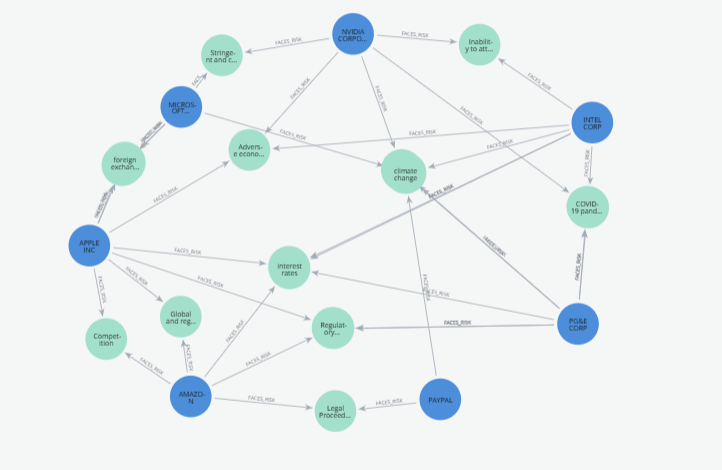

## Text2CypherRetriever Example ---

This section demonstrates how to use the `Text2CypherRetriever` to automatically generate Cypher queries from natural language questions.

**How it works:**
- The retriever uses a Large Language Model (LLM) to translate your plain-English query into a Cypher query, based on your Neo4j schema.
- The schema is provided as a string describing the main node types and relationships in your graph (e.g., companies, risk factors, asset managers).

**Example Workflow:**
1. You provide a natural language question, such as:
   > "What are the company names of companies owned by BlackRock Inc."
2. The retriever generates a corresponding Cypher query using the schema and the LLM.
3. The generated Cypher is printed, allowing you to inspect or execute it.

**Why this is powerful:**
- Removes the need to manually write Cypher for each question.
- Makes graph querying accessible to non-technical users.
- Great for rapid prototyping, exploration, and building natural language interfaces to your knowledge graph.



The following schema was retrieved from the connected Neo4j database using `get_schema(driver)`:


In [23]:
schema = get_schema(driver)
print(schema)

Node properties:
Document {id: STRING, path: STRING, createdAt: STRING}
Chunk {id: STRING, index: INTEGER, text: STRING, embedding: LIST}
Company {id: STRING, name: STRING, chunk_index: INTEGER, ticker: STRING}
Product {id: STRING, name: STRING, chunk_index: INTEGER}
RiskFactor {id: STRING, name: STRING, chunk_index: INTEGER}
FinancialMetric {id: STRING, name: STRING, chunk_index: INTEGER}
TimePeriod {id: STRING, name: STRING, chunk_index: INTEGER}
Transaction {id: STRING, name: STRING, chunk_index: INTEGER}
Executive {id: STRING, name: STRING, chunk_index: INTEGER}
StockType {id: STRING, name: STRING, chunk_index: INTEGER}
AssetManager {managerName: STRING, managerCik: INTEGER}
Relationship properties:
OWNS {position_status: STRING, Value: FLOAT, shares: INTEGER, share_value: FLOAT}
The relationships:
(:Chunk)-[:FROM_DOCUMENT]->(:Document)
(:Chunk)-[:NEXT_CHUNK]->(:Chunk)
(:Company)-[:MENTIONS]->(:Product)
(:Company)-[:MENTIONS]->(:TimePeriod)
(:Company)-[:MENTIONS]->(:Company)
(:Comp

In [24]:
# --- Text2CypherRetriever Example ---
from requests import session


print("\n--- Text2CypherRetriever Example ---")
text2cypher_retriever = Text2CypherRetriever(
    driver=driver,
    llm=llm,
    neo4j_schema= schema
)

query = "what are the company names of companies owned by BlackRock Inc."
cypher_query = text2cypher_retriever.get_search_results(query)
print("\n--- Text2Cypher Output ---")
print("Original Query:", query)
print("Generated Cypher:\n", cypher_query.metadata["cypher"])



--- Text2CypherRetriever Example ---

--- Text2Cypher Output ---
Original Query: what are the company names of companies owned by BlackRock Inc.
Generated Cypher:
 cypher
MATCH (a:AssetManager {managerName: 'BlackRock Inc.'})-[:OWNS]->(c:Company)
RETURN c.name AS company_name



## Executing the Generated Cypher Query

This section runs the Cypher query generated by the `Text2CypherRetriever` and displays the results.

**How it works:**
- The Cypher query, generated from your natural language question, is executed directly against the Neo4j database using the `driver`.
- Each record returned by the query is printed for inspection.

**Why this is useful:**
- Allows you to see the actual data returned from your graph for your question, closing the loop from natural language to structured results.
- Lets you verify both the correctness of the generated Cypher and the quality of the graph data.

**Typical workflow:**
1. Use the retriever to generate Cypher from your question.
2. Execute the Cypher and review the results.
3. Iterate on your question or schema as needed to improve answers.


In [25]:
result = driver.execute_query(cypher_query.metadata["cypher"])
for record in result.records:
    print(record)

<Record company_name='MICROSOFT CORP'>
<Record company_name='AMAZON'>
<Record company_name='APPLE INC'>
<Record company_name='NVIDIA CORPORATION'>
<Record company_name='INTEL CORP'>
<Record company_name='PG&E CORP'>
<Record company_name='MCDONALDS CORP'>
<Record company_name='PAYPAL HLDGS INC'>


## Next Steps & Troubleshooting

- Try different queries to explore your knowledge graph.
- If you encounter errors, check your environment variables and ensure all dependencies are installed.
- For advanced graph exploration, see the optional agent notebook (`03_Neo4j_agent_notebook.ipynb`).</p>

>
> **Need help?**  
> Refer to the project README or open an issue in the repository.